In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def bioreactor(t,z,HRT,SRT,influent):
    #HRT,SRT,influent are parameters that are passed into the 'bioreactor' by 'integrate.ode'
    
    #COMPONENTS
    
    S_AMD = z[0] #p-coumaroyl amide [mg p-coumaroyl amide/L]
    S_BEN = z[1] #4-hydroxybenzoic acid [mg 4-hydroxybenzoic acid/L]
    S_ACE = z[2] #acetic acid [mg acetic acid/L]
    S_NH4 = z[3] #ammonium [mg N/L]
    X_BEN = z[4] #p-coumaroyl amide & 4-hydroxybenzoic acid degrader [mg X_BEN/L]
    X_ACE = z[5] #acetic acid degrader [mg X_ACE/L]
    X_NH4 = z[6] #ammonium degrader [mg X_NH4/L]
    
    ##########
    
    #STOICHIOMETRIC & KINETIC PARAMETERS
    
    Y_BEN = 0.7 #yeild coefficient for X_BEN [mg VSS(X_BEN)/mg 4-hydroxybenzoic acid]
    K_BEN = 34 #half saturation constant for X_BEN degradation of 4-hydroxybenzoic acid [mg 4-hydroxybenzoic acid/L]
    q_BEN = 5 #maximum specific 4-hydroxybenzoic acid utilization rate by X_BEN [mg 4-hydroxybenzoic acid/mg VSS(X_BEN).day]
    b_BEN = 0.05 #endogenous decay coefficient for X_BEN [1/day]
    mu_BEN = Y_BEN*q_BEN #maximum specific growth rate of X_BEN [1/day]
    
    c_BEN = 0.846 #stoichiometric coefficeint of 4-hydroxybenzoic acid as a result of p-coumaroyl amide degradation [mg 4-hydroxybenzonic acid/mg p-coumaroyl amide]
    c_ACE = 0.368 #stoichiometric coefficeint of acetic acid as a result of p-coumaroyl amide degradation [mg acetic acid/mg p-coumaroyl amide]
    c_NH4 = 0.086 #stoichiometric coefficeint of ammonium as a result of p-coumaroyl amide degradation [mg N/mg p-coumaroyl amide]
    K_AMD = 15 #half saturation constant for X_BEN degradation of p-coumaroyl amide [mg p-coumaroyl amide/L]
    q_AMD = 5 #maximum specific p-coumaroyl amide utilization rate by X_BEN [mg p-coumaroyl amide/mg VSS(X_BEN).day]
    
    Y_ACE = 0.45 #yeild coefficient for X_ACE [mg VSS(X_ACE)/mg acetic acid]
    K_ACE = 10 #half saturation constant for X_ACE [mg acetic acid/L]
    q_ACE = 3 #maximum specific acetic acid utilization rate by X_ACE [mg acetic acid/mg VSS(X_ACE).day]
    b_ACE = 0.05 #endogenous decay coefficient for X_ACE [1/day]
    mu_ACE = Y_ACE*q_ACE  #maximum specific growth rate of X_ACE [1/day]
    
    Y_NH4 = 0.06 #yeild coefficeint for X_NH4 [mg VSS(X_NH4)/mg N]
    K_NH4 = 0.5 #half saturation constant for X_NH4 [mg N/L]
    q_NH4 = 2 #maximum specific ammonium utilization rate by X_NH4 [mg N/mg VSS(X_NH4).day]
    b_NH4 = 0.05 #endogenous decay coefficient for X_NH4 [1/day]
    mu_NH4 = Y_NH4*q_NH4  #maximum specific growth rate of X_NH4 [1/day]
    
    ###########
    
    #PROCESSES

    
    #1:p-coumaroyl amide degradation
    #stoichiometric array 
    P1=np.array([[-1,c_BEN,c_ACE,c_NH4,0,0,0]])
    #kinetic expresion
    K1=q_AMD*(S_AMD/(K_AMD+S_AMD))*X_BEN
    
    #2:X_BEN gorwth
    #stoichiometric array 
    P2=np.array([[0,-1/Y_BEN,0,0,1,0,0]])
    #kinetic expresion
    K2= mu_BEN*(S_BEN/(K_BEN+S_BEN))*X_BEN
    
    #3:X_BEN decay
    #stoichiometric array 
    P3=np.array([[0,0,0,0,-1,0,0]])
    #kinetic expresion
    K3=b_BEN*X_BEN
    
    #4: X_ACE growth
    #stoichiometric array
    P4=np.array([[0,0,-1/Y_ACE,0,0,1,0]])
    #kinetic expersion
    K4=mu_ACE*(S_ACE/(K_ACE+S_ACE))*X_ACE
    
    #5: X_ACE decay
    #stoichiometric array
    P5=np.array([[0,0,0,0,0,-1,0]])
    #kinetic expersion
    K5=b_ACE*X_ACE
    
    #6: X_NH4 growth
    #stoichiometric array
    P6=np.array([[0,0,0,-1/Y_NH4,0,0,1]])
    #kinetic expersion
    K6=mu_NH4*(S_NH4/(K_NH4+S_NH4))*X_NH4
    
    #7: X_NH4 decay
    #stoichiometric array
    P7=np.array([[0,0,0,0,0,0,-1]])
    #kinetic expersion
    K7=b_NH4*X_NH4
    
    #8: Discharge 
    #stoichiometric array
    P8=np.array([[-S_AMD/HRT,-S_BEN/HRT,-S_ACE/HRT,-S_NH4/HRT,-X_BEN/SRT,-X_ACE/SRT,-X_NH4/SRT]])
    #kinetic expersion
    K8=1
    
    ##########
    
    #LOADING
    
    load = (Q/V)*influent
    
    ##########
    
    #CALCULATION (DO NOT MODIFY)
    stoch = np.hstack((P1.T,P2.T,P3.T,P4.T,P5.T,P6.T,P7.T,P8.T)) #creating stoichiometric matrix by horizontal stakcing of transposed process stoichiometirc arrays
    kin = np.array([[K1,K2,K3,K4,K5,K6,K7,K8]]).T #creating kinetic array by combining individual process kinetics
    dotprod = np.dot(stoch,kin) #dot production of stoichiometric matrix and kinetic array
    dzdt=np.ndarray.flatten(dotprod)+load #combining kinectic 
    
    return dzdt

In [3]:
#set 'bioreactor' hydraulic rentention time, sludege age, and load
Q=4 # flowrate [L/day]
V=2 # reactor volume [L]
HRT = V/Q # hydraulic retention time [day]
SRT = 20 # sludge age / solid retention time  [day]

S_AMD_0=2000 # influent p-coumaroyl amide [mg p-coumaroyl amide/L]
S_BEN_0=0 #influent 4-hydroxybenzoic acid [mg 4-hydroxybenzoic acid/L]
S_ACE_0=0 #influent acetic acid [mg acetic acid/L]
S_NH4_0=0 #influent ammonium [mg N/L]
X_BEN_0=0 #influent p-coumaroyl amide & 4-hydroxybenzoic acid degrader [mg VSS (X_BEN)/L]
X_ACE_0=0 #influent acetic acid degrader [mg VSS (X_ACE)/L]
X_NH4_0=0 #influent ammonium degrader [mg VSS (X_NH4)/L]

#set start time, end time, and time steps
t_start = 0.0
t_final = 90
dt_minutes = 60 #time step in minutes
dt=dt_minutes/(60*24)

#set initial conditions
S_AMD_ini = S_AMD_0
S_BEN_ini = S_BEN_0
S_ACE_ini = S_ACE_0
S_NH4_ini = S_NH4_0
X_BEN_ini = 100
X_ACE_ini = 100
X_NH4_ini = 100

#setup solver
num_steps = np.floor((t_final-t_start)/dt)+1 #set number of steps taken be solver, +1 to account for t=0
influent=np.array([S_AMD_0,S_BEN_0,S_ACE_0,S_NH4_0,X_BEN_0,X_ACE_0,X_NH4_0]) # create influent array
z_ini = [S_AMD_ini,S_BEN_ini,S_ACE_ini,S_NH4_ini,X_BEN_ini,X_ACE_ini,X_NH4_ini] #creat initial conditions array
r = integrate.ode(bioreactor).set_integrator('vode', method='bdf') #select solver and method
r.set_initial_value(z_ini,t_start).set_f_params(HRT,SRT,influent) #pass initial condition and parameters into the solver

#create solution array, 'num_steps' is passed as 'int32' because 'astype' requires integers
t_sol=np.zeros((num_steps.astype(np.int32),1))
S_AMD_sol = np.zeros((num_steps.astype(np.int32),1))
S_BEN_sol = np.zeros((num_steps.astype(np.int32),1))
S_ACE_sol = np.zeros((num_steps.astype(np.int32),1))
S_NH4_sol = np.zeros((num_steps.astype(np.int32),1))
X_BEN_sol = np.zeros((num_steps.astype(np.int32),1))
X_ACE_sol = np.zeros((num_steps.astype(np.int32),1))
X_NH4_sol = np.zeros((num_steps.astype(np.int32),1))

#set first value in solution array to initial condition at t=0
t_sol[0] = t_start
S_AMD_sol[0] = S_AMD_ini
S_BEN_sol[0] = S_BEN_ini
S_ACE_sol[0] = S_ACE_ini
S_NH4_sol[0] = S_NH4_ini
X_BEN_sol[0] = X_BEN_ini
X_ACE_sol[0] = X_ACE_ini
X_NH4_sol[0] = X_NH4_ini

#solver driver
step_count=1
while r.successful() and step_count < num_steps:
    r.integrate(r.t+dt)
    t_sol[step_count]=r.t
    S_AMD_sol[step_count]=r.y[0]
    S_BEN_sol[step_count]=r.y[1]
    S_ACE_sol[step_count]=r.y[2]
    S_NH4_sol[step_count]=r.y[3]
    X_BEN_sol[step_count]=r.y[4]
    X_ACE_sol[step_count]=r.y[5]
    X_NH4_sol[step_count]=r.y[6]
    step_count +=1

(0.0, 1.0, 0.0, 1.0)

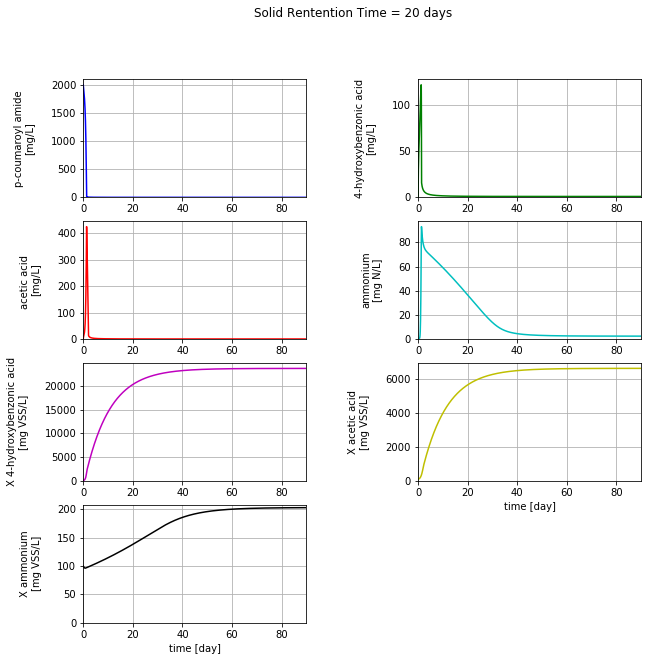

In [4]:
#Plot solution
SUM_PLOT, sing_plot = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
SUM_PLOT.subplots_adjust(wspace = 0.5)
SUM_PLOT.suptitle('Solid Rentention Time = %s days'% SRT)


sing_plot[0,0].plot(t_sol,S_AMD_sol, 'b-')
sing_plot[0,0].set_ylim(0,)
sing_plot[0,0].set_ylabel('p-coumaroyl amide\n[mg/L]\n')
sing_plot[0,0].set_xlim(0,t_final)
sing_plot[0,0].grid(1)

sing_plot[0,1].plot(t_sol,S_BEN_sol, 'g-')
sing_plot[0,1].set_ylim(0,)
sing_plot[0,1].set_ylabel('4-hydroxybenzonic acid\n[mg/L]\n')
sing_plot[0,1].set_xlim(0,t_final)
sing_plot[0,1].grid(1)

sing_plot[1,0].plot(t_sol,S_ACE_sol, 'r-')
sing_plot[1,0].set_ylim(0,)
sing_plot[1,0].set_ylabel('acetic acid \n[mg/L]\n')
sing_plot[1,0].set_xlim(0,t_final)
sing_plot[1,0].grid(1)

sing_plot[1,1].plot(t_sol,S_NH4_sol, 'c-')
sing_plot[1,1].set_ylim(0,)
sing_plot[1,1].set_ylabel('ammonium\n[mg N/L]\n')
sing_plot[1,1].set_xlim(0,t_final)
sing_plot[1,1].grid(1)

sing_plot[2,0].plot(t_sol,X_BEN_sol, 'm-')
sing_plot[2,0].set_ylim(0,)
sing_plot[2,0].set_ylabel('X 4-hydroxybenzonic acid\n[mg VSS/L]\n')
sing_plot[2,0].set_xlim(0,t_final)
sing_plot[2,0].grid(1)

sing_plot[2,1].plot(t_sol,X_ACE_sol, 'y-')
sing_plot[2,1].set_ylim(0,)
sing_plot[2,1].set_ylabel('X acetic acid\n[mg VSS/L]\n')
sing_plot[2,1].set_xlabel('time [day]')
sing_plot[2,1].set_xlim(0,t_final)
sing_plot[2,1].grid(1)

sing_plot[3,0].plot(t_sol,X_NH4_sol, 'k-')
sing_plot[3,0].set_ylim(0,)
sing_plot[3,0].set_ylabel('X ammonium\n[mg VSS/L]\n')
sing_plot[3,0].set_xlabel('time [day]')
sing_plot[3,0].set_xlim(0,t_final)
sing_plot[3,0].grid(1)

sing_plot[3,1].axis('off')